# Load the model (copy-paste from Axel)

In [48]:
# Batch Legal Mockup Model

#Imports

import pandas as pd
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Loading html-file + converting it into txt

file = open("../raw_data/test_data.html", "r")
data = BeautifulSoup(file)
as_txt = data.get_text()

#Tokenizing the sentences

as_sentences = sent_tokenize(as_txt)


#Transforming sentences into DF

txt_df = pd.DataFrame(as_sentences)
txt_df.head()

type(txt_df)

#Defining Davy's Preproc-Function

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercasing 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## removing numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## removing punctuation
    tokenized_sentence = word_tokenize(sentence) ## tokenizing 
    stop_words = set(stopwords.words('english')) ## defining stopwords
    tokenized_sentence_cleaned = [w for w in tokenized_sentence 
                                  if not w in stop_words] ## remove stopwords
    lemmatized = [WordNetLemmatizer().lemmatize(word, pos = "v")  # v --> verbs
              for word in tokenized_sentence_cleaned]
    cleaned_sentence = ' '.join(word for word in lemmatized)
    return cleaned_sentence

# Applying Davy's Function

clean_txt = txt_df[0].apply(cleaning)

#Checking outcome of Preprocessing
clean_txt

#Vectorizing data

vectorizer = CountVectorizer()
vectorized_text = vectorizer.fit_transform(clean_txt)

#Modelling

# Instantiating the LDA 
n_components = 3
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 100)

# Fitting the LDA on the vectorized documents
lda_model.fit(vectorized_text)

# Getting topics
topics = lda_model.transform(vectorized_text)

#Topic model function from ML-10-lecture
def print_topics(model, vectorizer, top_words):
    for idx, topic in enumerate(model.components_):
        print("-"*20)
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], round(topic[i],2))
                        for i in topic.argsort()[:-top_words - 1:-1]])

#Printing topics

print_topics(lda_model, vectorizer, top_words = 8)

--------------------
Topic 0:
[('public', 38.3), ('shall', 33.56), ('eec', 29.33), ('article', 21.6), ('state', 20.37), ('decision', 19.31), ('expulsion', 18.26), ('member', 17.71)]
--------------------
Topic 1:
[('member', 68.11), ('state', 67.23), ('residence', 65.39), ('right', 47.09), ('shall', 46.57), ('host', 38.3), ('permanent', 35.2), ('person', 21.47)]
--------------------
Topic 2:
[('member', 76.18), ('union', 73.13), ('state', 71.41), ('family', 48.91), ('article', 48.02), ('residence', 44.09), ('members', 43.46), ('citizens', 43.25)]


# Visualisation

## Getting data in right format

In [51]:
# adding random dates to clean_txt
def random_dates(start, end, n=10):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2018-01-01')

viz_text = pd.DataFrame(clean_txt)
viz_text['date'] = random_dates(start, end,len(clean_txt))

In [132]:
# Re-pasting the topics into the data

import numpy as np

def repaste_topics(topics,df):
    ''' Assigns the topics identified by LDA to each separate document. Input requires the df where the topics were sourced from, and the topics generated by LDA.
    df and topics must be same length. Returns df with an extra column 'topic'
    '''
    if len(topics) == len(df): # check if df and topics are same length
        assign_dict = {'topic':[]}
        for index,row in enumerate(topics):
            topic = np.where(row == np.max(row, axis=0))
            if len(topic) == 1:
                assign = "Topic " + str(topic[0][0])
            else:
                assign = "Multiple topics" # sometimes not a single topic can be assigned
            assign_dict['topic'].append(assign)
        df['topic'] = pd.DataFrame(assign_dict)
    else:
        print("Topics and source dataframe not the same length.")

    return df

## Visualization functions

In [131]:
import datetime
import plotly.express as px


def stack_chart(df,directory = "all directories"):
    '''
    Based on an input df with fields 'date' (datetime) and 'topic', this function generates a bar chart with the distribution of topics over time.
    
    For the chart title, specify the directory
    '''
    
    # Convert date-time to years
    
    df['year'] = df['date'].dt.year.astype(str)
    
    # Group by year and by topic, drop date
    output = viz_text.groupby(['year','topic']).count().reset_index().rename(columns={0:'count'})
    output = output.drop('date',axis=1)
    
    # Sort output
    output = output.sort_values(['year','topic'])
    
    fig = px.bar(output, x="year", y="count", color="topic", title=f"Bar chart of sub-topics for {directory}")
    fig.show()
    

In [192]:
!pip install wordcloud
import wordcloud
def top_topics_words(model, vectorizer, top_words):
    '''
    Based on a model, vectorizer, and top_words (integer), generate a dictionary of lists.
    
    Each dictionary key is one of the LDA-identified topics.
    
    Each dictionary key contains a list of top words
    '''
    out = {}
    for idx, topic in enumerate(model.components_):
        tpc = "Topic " + str(idx)
        out[tpc] = [(vectorizer.get_feature_names_out()[i])
                        for i in topic.argsort()[:-top_words - 1:-1]]
        #print([(vectorizer.get_feature_names_out()[i])
        #                for i in topic.argsort()[:-top_words - 1:-1]])
    return out

def generate_word_chart(top_words,topic=0):
    '''
    Supply a top_words dictionary and a topic number, and this will generate a wordcloud for that topic
    
    '''
    
    cloud = wordcloud.WordCloud(background_color="white", repeat=False)

    topic_in = "Topic "+str(topic)
    
    cloud.generate(text=' '.join(test[topic_in]))
    plt.imshow(cloud)
    plt.show()

## Visualisation carried out

In [133]:
stack_chart(repaste_topics(topics,viz_text))

/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/sit

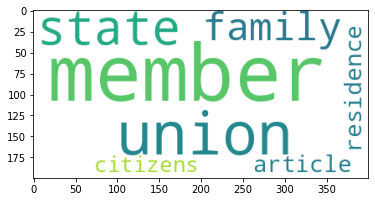

In [194]:
generate_word_chart(top_topics_words(lda_model,vectorizer,12),2)

In [ ]:
!pip install pyLDAvis
import pyLDAvis.sklearn

In [5]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, vectorized_text, vectorizer, mds='mmds')


/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008143  0.141410       1        1  57.027774
0      0.109090 -0.070749       2        1  32.392597
1     -0.117234 -0.070661       3        1  10.579630, topic_info=          Term       Freq      Total Category  logprob  loglift
564      shall  98.000000  98.000000  Default  30.0000  30.0000
180  directive  16.000000  16.000000  Default  29.0000  29.0000
492  provision  16.000000  16.000000  Default  28.0000  28.0000
493     public  33.000000  33.000000  Default  27.0000  27.0000
379        may  35.000000  35.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
338      issue   3.075722  23.388260   Topic3  -4.8651   0.2175
238   european   2.051814   5.563919   Topic3  -5.2699   1.2487
379        may   3.410089  35.606419   Topic3  -4.7619  -0.0995
449    persons   3.001016  28.177648   Topic3  -4.8896   0.0067
44     article   3.695159  73.817362   Topic3  -4.6816  -0.7483

[192 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
6         2  0.955478   access
13        1  0.904608  acquire
15        3  0.929419      act
20        2  0.501208    adopt
20        3  0.501208    adopt
...     ...       ...      ...
667       1  0.924331   worker
668       1  0.924326  workers
672       1  0.973622     year
673       1  0.777406    years
673       2  0.179401    years

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.pyenv/versions/3.8.13/envs/BatchLegal/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  fro